Random Forest: 0.6820


c:\Users\Kuldip\anaconda3\envs\kuldip\lib\site-packages\xgboost\core.py:158: UserWarning: [16:02:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Kuldip\anaconda3\envs\kuldip\lib\site-packages\xgboost\core.py:158: UserWarning: [16:02:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Kuldip\anaconda3\envs\kuldip\lib\site-packages\xgboost\core.py:158: UserWarning: [16:02:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\U

XGBoost: 0.6509
Accuracy: 0.6761658031088082
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.66      0.67       385
           1       0.67      0.69      0.68       387

    accuracy                           0.68       772
   macro avg       0.68      0.68      0.68       772
weighted avg       0.68      0.68      0.68       772



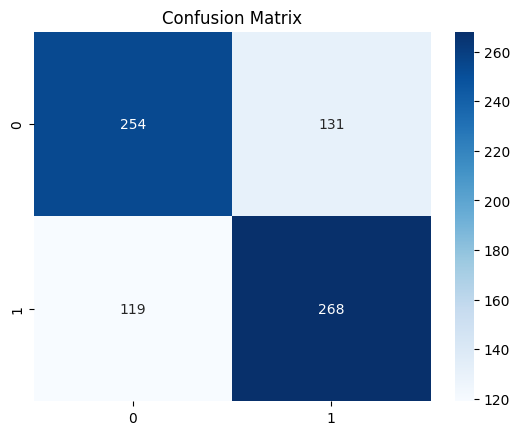

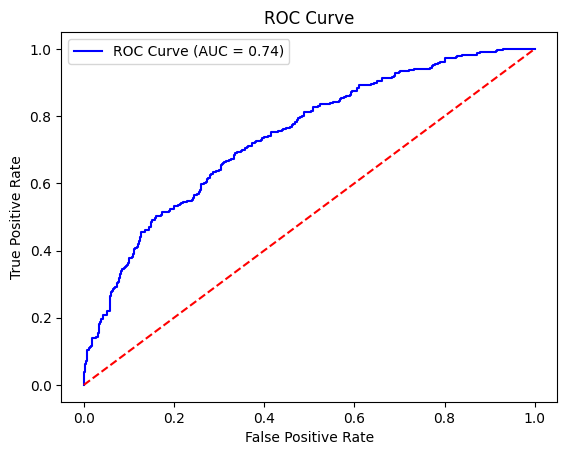

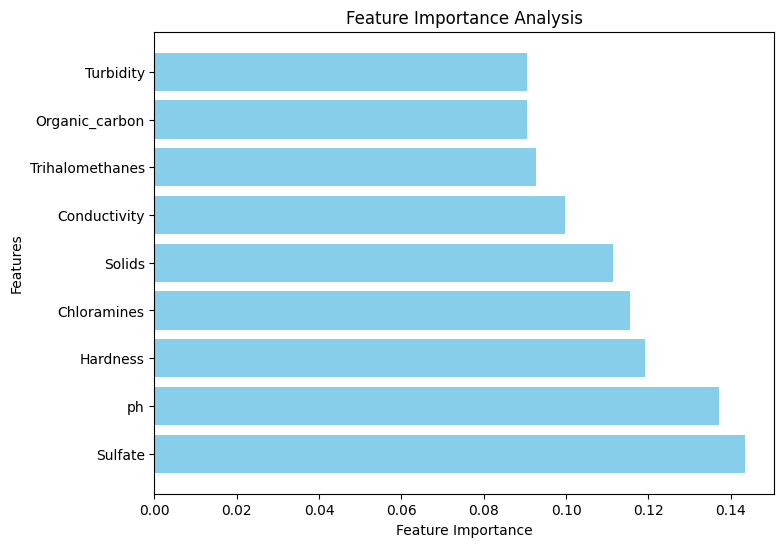

['water_potability_model.pkl']

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from scipy import stats

# Load Data
data = pd.read_csv('water_potability.csv')

# Data Preprocessing
data.fillna(data.median(), inplace=True)

# Outlier Detection and Removal
z_scores = stats.zscore(data.drop('Potability', axis=1))
data = data[(np.abs(z_scores) < 3).all(axis=1)]

# Handling Class Imbalance
X = data.drop('Potability', axis=1)
y = data['Potability']
smote = SMOTE(sampling_strategy='minority', random_state=42)
X, y = smote.fit_resample(X, y)

# Data Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Initialization
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Model Evaluation
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: {scores.mean():.4f}")

# Hyperparameter Tuning (XGBoost)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
params = {'n_estimators': [50, 100, 250, 400], 'learning_rate': [0.1, 0.2, 0.3, 0.5]}
grid_search = RandomizedSearchCV(xgb, param_distributions=params, cv=5, n_iter=10, random_state=42)
grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Model Evaluation Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Feature Importance (Tree-Based Models)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    features = data.drop('Potability', axis=1).columns
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 6))
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title("Feature Importance Analysis")
    plt.show()

# Save Scaler and Model
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(best_model, 'water_potability_model.pkl')
